# myrun

This notebook imports the feature vector, merges it with the labelled data and then makes predictions on specified columns


In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce

# Igel
from igel import Igel

# Compare Algorithms
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [27]:
def clean_dataset_int(df):
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.replace(np.nan,0)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    df = df.replace(r'\D+', '', regex=True)
    return df[indices_to_keep].astype(np.float64)

In [28]:
# Set the column names
feature_vector_keys = ["timestamp", "tweet_id", "positive_sentiment", "negative_sentiment", \
                       "numb_of_mentions", "numb_of_urls", "numb_of_media","numb_of_hashtags", \
                       "numb_of_personal_pronouns", "numb_of_present_tenses", "numb_of_past_tenses", \
                       "sent_from_web", "numb_of_weird_chars", "numb_of_questions", "numb_of_emoticons", \
                       "numb_of_swearing_words", "numb_of_slang_words", "numb_of_intensifiers", \
                       "tweet_length", "userFollowersCount","userFriendsCount", "user_numb_of_tweets",\
                       "user_list_count", "tfidf_fire", "dict_precision", "dict_recall", "dict_f_measure"
                       ]


priority_scorer = {
    '10.' : 'Critical',
    '9.0' : 'Critical',
    '8.0' : 'High',
    '7.0' : 'High',
    '6.0' : 'High',
    '5.0' : 'Medium',
    '4.0' : 'Medium',
    '3.0' : 'Low',
    '2.0' : 'Low',
    '1.0' : 'Low',
    '0.0' : 'Low',
}

priority_mapping = {
    "Critical" : 10,
    "High" : 7.5,
    "Medium" : 5,
    "Low" : 2.5,
    "Unknown" : 0,
}

# What we consider to be highly important categories of information
highCategoriser = {
    0.0 : 'Other-Advice',
    1.0 : 'Other-Advice',
    2.0 : 'Report-CleanUp',
    3.0 : 'ContextualInformation',
    4.0 : 'Other-ContextualInformation',
    5.0 : 'CallToAction-Donations',
    6.0 : 'Report-EmergingThreats',
    7.0 : 'Report-Factoid',
    8.0 : 'Report-FirstPartyObservation',
    9.0 : 'Request-GoodsServices',
    10.0 : 'Report-Hashtags',
    11.0 : 'Request-InformationWanted',
    12.0 : 'Other-Irrelevant',
    13.0 : 'Report-Location',
    14.0 : 'CallToAction-MovePeople',
    15.0 : 'Report-MultimediaShare',
    16.0 : 'Report-NewSubEvent',
    17.0 : 'Report-News',
    18.0 : 'Report-Official',
    19.0 : 'Report-OriginalEvent',
    20.0 : 'Request-SearchAndRescue',
    21.0 : 'Other-Sentiment',
    22.0 : 'Report-ServiceAvailable',
    23.0 : 'Report-ThirdPartyObservation',
    24.0 : 'CallToAction-Volunteer',
    25.0 : 'Report-Weather',
    26.0 : 'hmm',
}

event_int_map =	{
  "guatemalaEarthquake2012": 7,
  "joplinTornado2011": 16,
  "athensEarthquake2020": 35,
  "baltimoreFlashFlood2020": 36,
  "brooklynBlockPartyShooting2020": 37,
  "daytonOhioShooting2020": 38,
  "elPasoWalmartShooting2020": 39,
  "gilroygarlicShooting2020": 40,
  "hurricaneBarry2020": 41,
  "indonesiaEarthquake2020": 42,
  "keralaFloods2020": 43,
  "myanmarFloods2020": 44,
  "papuaNewguineaEarthquake2020": 45,
  "siberianWildfires2020": 46,
  "typhoonKrosa2020": 47,
  "typhoonLekima2020": 48,
  "whaleyBridgeCollapse2020": 49
}

mymap = {'Advice':1, 'CleanUp':2, 'ContextualInformation':3, 'Discussion':4, 'Donations':5, 
        'EmergingThreats':6, 'Factoid':7, 'FirstPartyObservation':8, 'GoodsServices':9, 'Hashtags':10, 
        'InformationWanted':11,'Irrelevant':12, 'Location':13, 'MovePeople':14, 
         'MultimediaShare':15, 'NewSubEvent':16, 'News':17,
        'Official':18, 'OriginalEvent':19, 'SearchAndRescue':20, 'Sentiment':21, 'ServiceAvailable':22, 
         'ThirdPartyObservation':23,'Volunteer':24, 'Weather':25}

## Feature Vector

Load the feature vector in from Play

In [32]:
# Currently loading the feature vector from a .txt file exported from Play
feature_vector_input = pd.read_csv("../../../0-data/processed/all_new.txt", sep=",", header=None)

# Set the column names
feature_vector_input.columns = feature_vector_keys

# Group by tweet
#feature_vector_input = feature_vector_input.groupby(['tweet_id']).agg('first')

# Reset the index
feature_vector_input.reset_index(level=0, inplace=True)

# Clean & drop empty rows
#feature_vector_input = clean_initial_feature_vector(feature_vector_input)

# Create a numeric version for our model
feature_vector_input = clean_dataset_int(feature_vector_input)

feature_vector_input

,index,timestamp,tweet_id,positive_sentiment,negative_sentiment,numb_of_mentions,numb_of_urls,numb_of_media,numb_of_hashtags,numb_of_personal_pronouns,...,numb_of_intensifiers,tweet_length,userFollowersCount,userFriendsCount,user_numb_of_tweets,user_list_count,tfidf_fire,dict_precision,dict_recall,dict_f_measure
0,0.0,1.564909e+11,1.157940e+18,16.0,28.0,2.0,0.0,0.0,0.0,0.0,...,0.0,53.0,4993.0,5386.0,0.0,15.0,0.0,0.0,0.0,0.0
1,1.0,1.565126e+11,1.158848e+18,23.0,28.0,2.0,0.0,1.0,0.0,0.0,...,0.0,99.0,11344.0,11196.0,0.0,217.0,0.0,0.0,0.0,0.0
2,2.0,1.564879e+11,1.157814e+18,15.0,14.0,0.0,1.0,0.0,0.0,0.0,...,0.0,75.0,54.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,1.565109e+10,1.158776e+18,1.0,56.0,3.0,0.0,0.0,0.0,0.0,...,0.0,74.0,179.0,202.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4.0,1.565130e+11,1.158866e+18,4.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,53.0,4.0,98.0,0.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30908,30908.0,1.564681e+11,1.156982e+18,15.0,14.0,0.0,0.0,1.0,0.0,0.0,...,0.0,103.0,194.0,272.0,0.0,0.0,0.0,0.0,0.0,0.0
30909,30909.0,1.564671e+10,1.156938e+18,12.0,47.0,0.0,0.0,1.0,0.0,0.0,...,0.0,91.0,140693.0,2219.0,0.0,1150.0,0.0,0.0,0.0,0.0
30910,30910.0,1.564664e+11,1.156913e+18,2.0,64.0,0.0,0.0,1.0,0.0,0.0,...,0.0,76.0,77.0,96.0,0.0,0.0,0.0,0.0,0.0,0.0
30911,30911.0,1.564665e+10,1.156916e+18,2.0,66.0,0.0,0.0,1.0,0.0,0.0,...,0.0,66.0,294.0,19.0,0.0,4.0,0.0,0.0,0.0,0.0


## Load the labelled data

These are generated in 0_Labels.ipynb

In [33]:
# dtypes needs to be specified or long ints will change
labels_df = pd.read_json("../../../0-data/raw/data/2020/2020-A/labels/TRECIS-2018-2020A-labels.json", dtype={} )

# replace the event with a numeric value
labels_df = labels_df.replace({'eventID': event_int_map})

# Count the number of labels
labels_df['num'] = labels_df['postCategories'].str.len()


# Map the priority to a numeric value
labels_df = labels_df.replace({"postPriority": priority_mapping})

# Split categories and map to numeric values
category_list = pd.DataFrame(labels_df["postCategories"].to_list(), columns=['cat1', 'cat2', 'cat3',
                                                                   'cat4', 'cat5', 'cat6',
                                                                   'cat7', 'cat8', 'cat9', 'cat10'])


# Map the categories to numeric values
category_list = category_list.applymap(lambda s: mymap.get(s) if s in mymap else s)


# Join back onto our original list
labels = labels_df.join(category_list)

# Drop the string categories
labels.drop(['postCategories'], axis = 1, inplace = True)

# Tidy
labels = labels.drop(['eventName', 'eventDescription', 'eventType'], axis=1)


# Fill the NaN slots with 0
labels = labels.fillna("0")

# Export
labels.to_csv("../3-csv/labels.csv", index=False)

labels = clean_dataset_int(labels)

#labels = labels.loc[labels['eventID'] < 50]
#labels = labels.loc[labels['eventID'] > 40]

labels

,eventID,postID,postPriority,num,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10
0,16.0,7.267628e+16,2.5,3.0,7.0,10.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,16.0,7.267840e+16,10.0,4.0,22.0,18.0,10.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16.0,7.268240e+16,2.5,2.0,21.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16.0,7.269393e+16,5.0,3.0,23.0,10.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16.0,7.269856e+16,2.5,3.0,23.0,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42946,47.0,1.162000e+18,2.5,1.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42947,47.0,1.162005e+18,2.5,3.0,13.0,15.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42948,47.0,1.162005e+18,2.5,2.0,13.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42949,47.0,1.162006e+18,2.5,3.0,13.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train


Merges the input feature vector with the labels

In [35]:
#dfs = [labels, feature_vector_input]
#train = reduce(lambda left,right: pd.merge(left = 'tweet_id', right = 'postID'), dfs)

train = pd.merge(labels, feature_vector_input, left_on = 'postID', right_on = 'tweet_id', how = 'inner')

train.to_csv("../3-csv/train.csv", index=False)

train

,eventID,postID,postPriority,num,cat1,cat2,cat3,cat4,cat5,cat6,...,numb_of_intensifiers,tweet_length,userFollowersCount,userFriendsCount,user_numb_of_tweets,user_list_count,tfidf_fire,dict_precision,dict_recall,dict_f_measure
0,45.0,1.128285e+18,7.5,2.0,13.0,7.0,0.0,0.0,0.0,0.0,...,0.0,219.0,4416.0,4860.0,0.0,29.0,0.0,0.0,0.0,0.0
1,45.0,1.128285e+18,7.5,2.0,13.0,7.0,0.0,0.0,0.0,0.0,...,0.0,219.0,4416.0,4860.0,0.0,29.0,0.0,0.0,0.0,0.0
2,45.0,1.128286e+18,2.5,2.0,13.0,7.0,0.0,0.0,0.0,0.0,...,0.0,114.0,4680.0,4.0,0.0,107.0,0.0,0.0,0.0,0.0
3,45.0,1.128286e+18,2.5,2.0,13.0,7.0,0.0,0.0,0.0,0.0,...,0.0,114.0,4680.0,4.0,0.0,107.0,0.0,0.0,0.0,0.0
4,45.0,1.128286e+18,2.5,3.0,13.0,7.0,10.0,0.0,0.0,0.0,...,0.0,235.0,13.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18031,47.0,1.162005e+18,2.5,2.0,13.0,15.0,0.0,0.0,0.0,0.0,...,0.0,98.0,83.0,328.0,0.0,0.0,0.0,0.0,0.0,0.0
18032,47.0,1.162005e+18,2.5,2.0,13.0,15.0,0.0,0.0,0.0,0.0,...,0.0,98.0,83.0,328.0,0.0,0.0,0.0,0.0,0.0,0.0
18033,47.0,1.162006e+18,2.5,4.0,13.0,15.0,10.0,17.0,0.0,0.0,...,0.0,117.0,3368.0,181.0,0.0,1548.0,0.0,0.0,0.0,0.0
18034,47.0,1.162006e+18,2.5,4.0,13.0,15.0,10.0,17.0,0.0,0.0,...,0.0,117.0,3368.0,181.0,0.0,1548.0,0.0,0.0,0.0,0.0


### Test


Drops the categories, number of categories and priority so we can make our prediction

In [7]:
test = train

# Drop cat*
test.drop(list(test.filter(regex = 'cat')), axis = 1, inplace = True)

# Drop priority / num (of labels)
test.drop(['postPriority', 'num'], axis = 1, inplace = True)

# export
test.to_csv("../3-csv/test.csv", index=False)

test

,eventID,postID,index,timestamp,tweet_id,positive_sentiment,negative_sentiment,numb_of_mentions,numb_of_urls,numb_of_media,...,numb_of_intensifiers,tweet_length,userFollowersCount,userFriendsCount,user_numb_of_tweets,user_list_count,tfidf_fire,dict_precision,dict_recall,dict_f_measure
0,45.0,1.128285e+18,20682.0,1.557839e+11,1.128285e+18,3.0,60.0,0.0,0.0,2.0,...,0.0,219.0,4416.0,4860.0,0.0,29.0,0.0,0.0,0.0,0.0
1,45.0,1.128285e+18,30182.0,1.557839e+11,1.128285e+18,3.0,60.0,0.0,0.0,2.0,...,0.0,219.0,4416.0,4860.0,0.0,29.0,0.0,0.0,0.0,0.0
2,45.0,1.128286e+18,20489.0,1.557839e+11,1.128286e+18,3.0,65.0,0.0,0.0,1.0,...,0.0,114.0,4680.0,4.0,0.0,107.0,0.0,0.0,0.0,0.0
3,45.0,1.128286e+18,29989.0,1.557839e+11,1.128286e+18,3.0,65.0,0.0,0.0,1.0,...,0.0,114.0,4680.0,4.0,0.0,107.0,0.0,0.0,0.0,0.0
4,45.0,1.128286e+18,11203.0,1.557839e+11,1.128286e+18,3.0,54.0,0.0,0.0,1.0,...,0.0,235.0,13.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18031,47.0,1.162005e+18,18870.0,1.565879e+11,1.162005e+18,8.0,51.0,0.0,0.0,1.0,...,0.0,98.0,83.0,328.0,0.0,0.0,0.0,0.0,0.0,0.0
18032,47.0,1.162005e+18,28370.0,1.565879e+11,1.162005e+18,8.0,51.0,0.0,0.0,1.0,...,0.0,98.0,83.0,328.0,0.0,0.0,0.0,0.0,0.0,0.0
18033,47.0,1.162006e+18,9740.0,1.565879e+11,1.162006e+18,5.0,61.0,0.0,0.0,2.0,...,0.0,117.0,3368.0,181.0,0.0,1548.0,0.0,0.0,0.0,0.0
18034,47.0,1.162006e+18,18884.0,1.565879e+11,1.162006e+18,5.0,61.0,0.0,0.0,2.0,...,0.0,117.0,3368.0,181.0,0.0,1548.0,0.0,0.0,0.0,0.0


## Igel

This notebook implements `Igel`

> Igel supports all sklearn's machine learning functionality,

Igel's supported models:

        +--------------------+----------------------------+-------------------------+
        |      regression    |        classification      |        clustering       |
        +--------------------+----------------------------+-------------------------+
        |   LinearRegression |         LogisticRegression |                  KMeans |
        |              Lasso |                      Ridge |     AffinityPropagation |
        |          LassoLars |               DecisionTree |                   Birch |
        | BayesianRegression |                  ExtraTree | AgglomerativeClustering |
        |    HuberRegression |               RandomForest |    FeatureAgglomeration |
        |              Ridge |                 ExtraTrees |                  DBSCAN |
        |  PoissonRegression |                        SVM |         MiniBatchKMeans |
        |      ARDRegression |                  LinearSVM |    SpectralBiclustering |
        |  TweedieRegression |                      NuSVM |    SpectralCoclustering |
        | TheilSenRegression |            NearestNeighbor |      SpectralClustering |
        |    GammaRegression |              NeuralNetwork |               MeanShift |
        |   RANSACRegression | PassiveAgressiveClassifier |                  OPTICS |
        |       DecisionTree |                 Perceptron |                    ---- |
        |          ExtraTree |               BernoulliRBM |                    ---- |
        |       RandomForest |           BoltzmannMachine |                    ---- |
        |         ExtraTrees |       CalibratedClassifier |                    ---- |
        |                SVM |                   Adaboost |                    ---- |
        |          LinearSVM |                    Bagging |                    ---- |
        |              NuSVM |           GradientBoosting |                    ---- |
        |    NearestNeighbor |        BernoulliNaiveBayes |                    ---- |
        |      NeuralNetwork |      CategoricalNaiveBayes |                    ---- |
        |         ElasticNet |       ComplementNaiveBayes |                    ---- |
        |       BernoulliRBM |         GaussianNaiveBayes |                    ---- |
        |   BoltzmannMachine |      MultinomialNaiveBayes |                    ---- |
        |           Adaboost |                       ---- |                    ---- |
        |            Bagging |                       ---- |                    ---- |
        |   GradientBoosting |                       ---- |                    ---- |
        +--------------------+----------------------------+-------------------------+

### Fit



In [8]:
params = {
        'cmd': 'fit',    # provide the command you want to use. whether fit, evaluate or predict
        'data_path': "../3-csv/train.csv",
        'yaml_path': 'yaml/multi.yaml'  # DecisionTree
}

Igel(**params)

INFO - Entered CLI args: {'cmd': 'fit', 'data_path': '../3-csv/train.csv', 'yaml_path': 'yaml/multi.yaml'}
INFO - Executing command: fit ...
INFO - reading data from ../3-csv/train.csv
INFO - You passed the configurations as a yaml file.
INFO - your chosen configuration: {'dataset': {'split': {'test_size': 0.2, 'shuffle': True, 'stratify': 'default', 'scale': {'method': 'standard', 'target': 'inputs'}}}, 'model': {'type': 'regression', 'algorithm': 'DecisionTree'}, 'target': ['postPriority', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'num']}
INFO - dataset_props: {'split': {'test_size': 0.2, 'shuffle': True, 'stratify': 'default', 'scale': {'method': 'standard', 'target': 'inputs'}}} 
model_props: {'type': 'regression', 'algorithm': 'DecisionTree'} 
 target: ['postPriority', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'num'] 

INFO - dataset shape: (18036, 42)
INFO - dataset attributes: ['eventID', 'postID', 'po

### Evaluate



In [9]:
params = {
        'cmd': 'evaluate',    
        'data_path': "../3-csv/train.csv",
        'yaml_path': 'yaml/hyper.yaml'


}

Igel(**params)

INFO - Entered CLI args: {'cmd': 'evaluate', 'data_path': '../3-csv/train.csv', 'yaml_path': 'yaml/hyper.yaml'}
INFO - Executing command: evaluate ...
INFO - reading data from ../3-csv/train.csv
INFO - path of the pre-fitted model => /Users/mark/Documents/GitHub/HelpMe-clone/1-src/2-python/2-notebooks/model_results/model.sav
INFO - result path: /Users/mark/Documents/GitHub/HelpMe-clone/1-src/2-python/2-notebooks/model_results 
INFO - loading model form /Users/mark/Documents/GitHub/HelpMe-clone/1-src/2-python/2-notebooks/model_results/model.sav 
INFO - dataset shape: (18036, 42)
INFO - dataset attributes: ['eventID', 'postID', 'postPriority', 'num', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'index', 'timestamp', 'tweet_id', 'positive_sentiment', 'negative_sentiment', 'numb_of_mentions', 'numb_of_urls', 'numb_of_media', 'numb_of_hashtags', 'numb_of_personal_pronouns', 'numb_of_present_tenses', 'numb_of_past_tenses', 'sent_from_web', 'numb_of_weird_c

### Predict



In [10]:
params = {
        'cmd': 'predict',    
        'data_path': "../3-csv/test.csv",
        'yaml_path': 'yaml/hyper.yaml'

}

Igel(**params)

INFO - Entered CLI args: {'cmd': 'predict', 'data_path': '../3-csv/test.csv', 'yaml_path': 'yaml/hyper.yaml'}
INFO - Executing command: predict ...
INFO - reading data from ../3-csv/test.csv
INFO - path of the pre-fitted model => /Users/mark/Documents/GitHub/HelpMe-clone/1-src/2-python/2-notebooks/model_results/model.sav
INFO - loading from /Users/mark/Documents/GitHub/HelpMe-clone/1-src/2-python/2-notebooks/model_results/model.sav
INFO - dataset shape: (18036, 30)
INFO - dataset attributes: ['eventID', 'postID', 'index', 'timestamp', 'tweet_id', 'positive_sentiment', 'negative_sentiment', 'numb_of_mentions', 'numb_of_urls', 'numb_of_media', 'numb_of_hashtags', 'numb_of_personal_pronouns', 'numb_of_present_tenses', 'numb_of_past_tenses', 'sent_from_web', 'numb_of_weird_chars', 'numb_of_questions', 'numb_of_emoticons', 'numb_of_swearing_words', 'numb_of_slang_words', 'numb_of_intensifiers', 'tweet_length', 'userFollowersCount', 'userFriendsCount', 'user_numb_of_tweets', 'user_list_count

## View the predictions

In [11]:
predictions = pd.read_csv("model_results/predictions.csv")
predictions

def is_neg_predictions(predictions):
    predictions = predictions.sort_values(by=['postPriority'])
    predictions = predictions[(predictions > 0).all(1)]
    predictions.round()
    
is_neg_predictions(predictions)

INFO - NumExpr defaulting to 8 threads.


### Merge the new predictions back onto dataframe with the missing columns

In [12]:
# Map the labels to their High Level Information Types
cat_list = predictions.filter(regex='cat', axis=1).round().applymap(lambda x: highCategoriser[x])
predictions = cat_list.combine_first(predictions)

# Merge the predictions back into the training set
df = test.merge(predictions, left_index=True, right_index=True)
df

,eventID,postID,index,timestamp,tweet_id,positive_sentiment,negative_sentiment,numb_of_mentions,numb_of_urls,numb_of_media,...,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,num,postPriority
0,45.0,1.128285e+18,20682.0,1.557839e+11,1.128285e+18,3.0,60.0,0.0,0.0,2.0,...,Report-Factoid,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,2.0,7.5
1,45.0,1.128285e+18,30182.0,1.557839e+11,1.128285e+18,3.0,60.0,0.0,0.0,2.0,...,Report-Factoid,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,2.0,7.5
2,45.0,1.128286e+18,20489.0,1.557839e+11,1.128286e+18,3.0,65.0,0.0,0.0,1.0,...,Report-Factoid,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,2.0,2.5
3,45.0,1.128286e+18,29989.0,1.557839e+11,1.128286e+18,3.0,65.0,0.0,0.0,1.0,...,Report-Factoid,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,2.0,2.5
4,45.0,1.128286e+18,11203.0,1.557839e+11,1.128286e+18,3.0,54.0,0.0,0.0,1.0,...,Report-Factoid,Report-Hashtags,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,3.0,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18031,47.0,1.162005e+18,18870.0,1.565879e+11,1.162005e+18,8.0,51.0,0.0,0.0,1.0,...,Report-MultimediaShare,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,2.0,2.5
18032,47.0,1.162005e+18,28370.0,1.565879e+11,1.162005e+18,8.0,51.0,0.0,0.0,1.0,...,Report-MultimediaShare,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,2.0,2.5
18033,47.0,1.162006e+18,9740.0,1.565879e+11,1.162006e+18,5.0,61.0,0.0,0.0,2.0,...,Report-MultimediaShare,Report-Hashtags,Report-News,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,4.0,2.5
18034,47.0,1.162006e+18,18884.0,1.565879e+11,1.162006e+18,5.0,61.0,0.0,0.0,2.0,...,Report-MultimediaShare,Report-Hashtags,Report-News,Other-Advice,Other-Advice,Other-Advice,Other-Advice,Other-Advice,4.0,2.5


In [13]:
# Append the predicted categories to a list in a new column
df['predicted_categories'] = df[['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10']].values.tolist()


# Get the number of categories into something we can use to index
df['num'] = df['num'].astype(float).astype(int)

# Remove categories beyond what the tweet is predicted to have
df['categories'] = df.apply(lambda x: x['predicted_categories'][0:x['num']], axis=1)


# Clean
df = df.filter(['eventID', 'tweet_id', 'postPriority', 'eventID','categories'], axis=1).round()

#df = clean_dataset_int(df)
df


,eventID,tweet_id,postPriority,eventID,categories
0,45.0,1.128285e+18,8.0,45.0,"[Report-Location, Report-Factoid]"
1,45.0,1.128285e+18,8.0,45.0,"[Report-Location, Report-Factoid]"
2,45.0,1.128286e+18,2.0,45.0,"[Report-Location, Report-Factoid]"
3,45.0,1.128286e+18,2.0,45.0,"[Report-Location, Report-Factoid]"
4,45.0,1.128286e+18,2.0,45.0,"[Report-Location, Report-Factoid, Report-Hasht..."
...,...,...,...,...,...
18031,47.0,1.162005e+18,2.0,47.0,"[Report-Location, Report-MultimediaShare]"
18032,47.0,1.162005e+18,2.0,47.0,"[Report-Location, Report-MultimediaShare]"
18033,47.0,1.162006e+18,2.0,47.0,"[Report-Location, Report-MultimediaShare, Repo..."
18034,47.0,1.162006e+18,2.0,47.0,"[Report-Location, Report-MultimediaShare, Repo..."


## Export

Export in the TRECIS format

In [14]:
#testy = pd.read_csv("../3-csv/testy.csv")
#testy

In [15]:
# write to .run file
with open("marks2.run" , "w") as out_file:
    for row in df.drop_duplicates(subset="tweet_id").itertuples():
        #print("row:", row)
        content = [
            "TRECIS-CTIT-H-Test-0" + str(row.eventID),
            "Q0",          
            np.int64(row.tweet_id),   
            getattr(row, 'Index'),  #ToDo: Fix?
            #row.priority,
            str(priority_scorer[str(row.postPriority)[:3]]),  #ToDo: Fix
            row.categories,
            "marksrun2"
        ]
        out_file.write("\t".join([str(x) for x in content]) + "\n")

In [225]:
# Set the figure size
rcParams['figure.figsize'] = 20,10

In [282]:
data = pd.read_csv('../../../2-status_report/results2.txt', sep="&")



data


,marksrun,0.3708,0.0000,0.0000 .1,0.0000 .2,0.0000 ›,0.9287,0.0646,0.1779,
0,marksrun,0.3695,0.0000,0.0000,0.0000,0.0000,0.9287,0.0646,0.1779,
1,marksrun,0.3705,0.0000,0.0000,0.0000,0.0000,0.9285,0.0640,0.1505,
2,marksrun2,0.3723,0.0000,0.0000,0.0000,0.0000,0.9285,0.0640,0.1505,
3,marksrun2,0.3710,0.0000,0.0000,0.0000,0.0000,0.9285,0.0640,0.1505,
4,marksrun2,0.3690,0.0000,0.0000,0.0000,0.0000,0.9285,0.0546,0.1686,Multiple labels now mapping
5,marksrun2,0.3690,0.0000,0.0000,0.0000,0.0000,0.9287,0.0646,0.1779,
6,marksrun2,0.3746,0.0000,0.0000,0.0000,0.0000,0.9287,0.0739,0.1841,Fixed label capitalisation
7,marksrun2,0.3741,0.0000,0.0000,0.0220,0.0323,0.9292,0.0733,0.1636,Adding events in
8,marksrun2,0.3973,-0.0020,-0.0010,0.0017,0.0253,0.9307,0.0776,0.1713,
9,marksrun2,0.3993,-0.0013,-0.0007,0.0950,0.0980,0.9319,0.0855,0.2017,


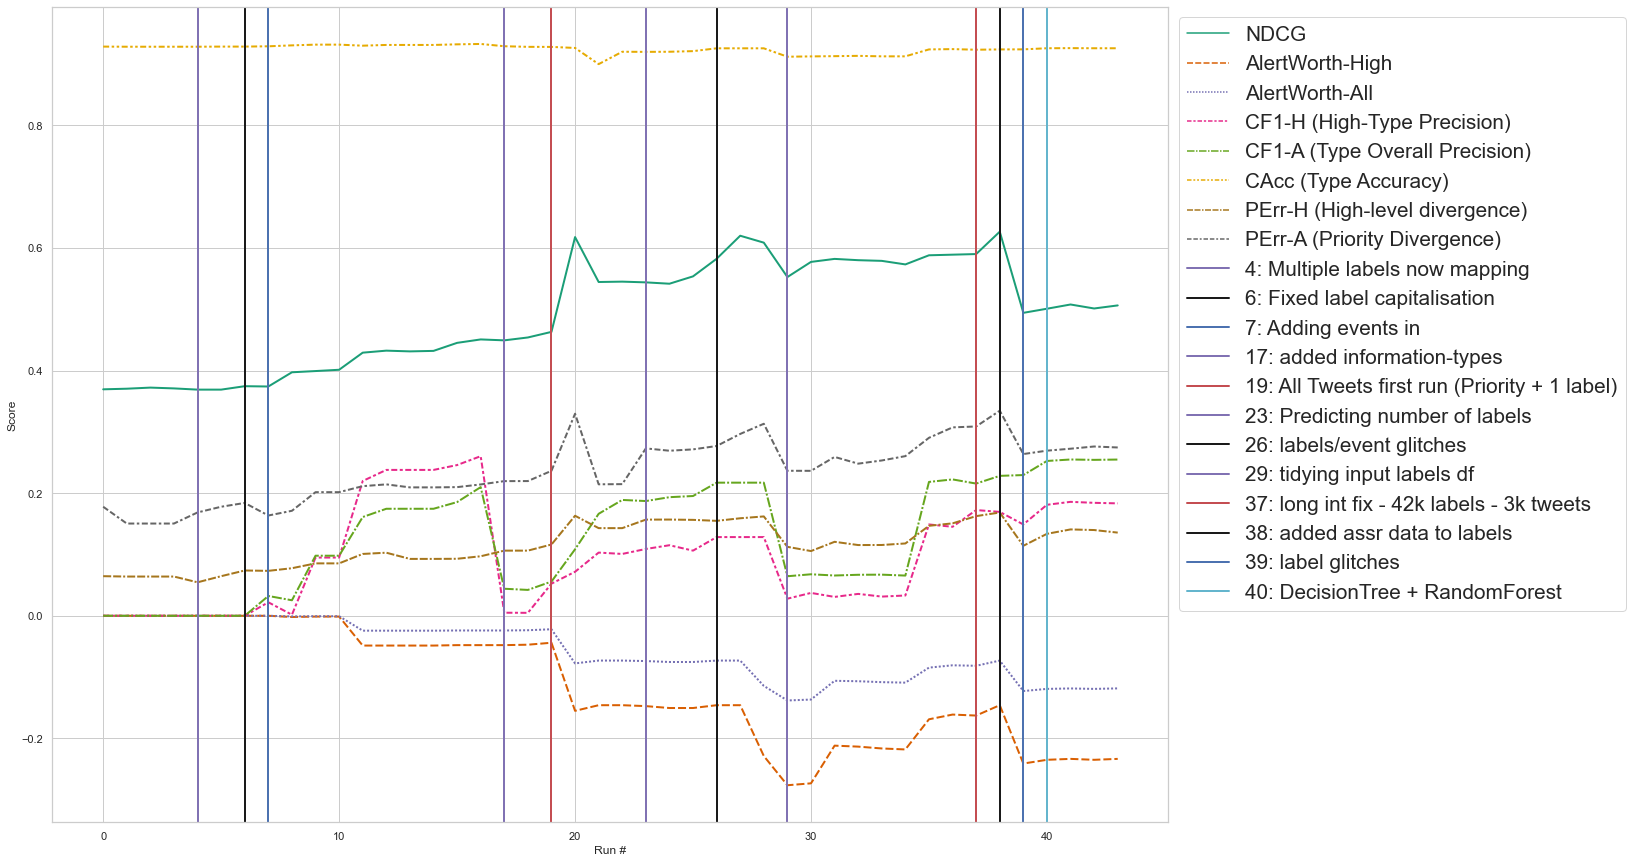

In [283]:
data.columns = ["run", "NDCG", "AlertWorth-High" , "AlertWorth-All" , "CF1-H (High-Type Precision)" , "CF1-A (Type Overall Precision)" , "CAcc (Type Accuracy)" , "PErr-H (High-level divergence)", "PErr-A (Priority Divergence)", "Notes"]


ax = sns.lineplot(data=data, palette="Dark2", linewidth=2, linestyle='--')
ax.set(xlabel="Run #", ylabel = "Score")
# Increase the font-size for the legend
#fig.suptitle('Marks runs')


plt.savefig('../../../0-data/screenshots/results.png',dpi=300)
# x coordinates for the lines
xcoords = [0.1, 0.3, 0.5]
# colors for the lines
colors = ['r','k','b','c','m','r','k','b','c','m','y','r','m','r','k','b','c','m','y','r','k','b','c','m','y','r','k','b','c','m','y','r','k','b','c','m','y','r','k','b','c','m','y']


i = -1    
for row, c, in zip(data.iterrows(),colors):
    #print(row.index)
    i = i+1
    if(len(row[1].Notes) != 1):
        ax.axvline(x=i, label=str(i) + ":" + row[1].Notes , c=colors[i], linestyle='-', linewidth=2)


#plt.axvline(x=7, label='Multiple labels now mapping', c='y')
#plt.axvline(x=19, label='All event tweets loaded (~10k)', c='m')
#plt.axvline(x=29, label='Predicting number of labels'.format(xc), c='k')
#plt.axvline(x=36, label='DecisionTree', c='g')
#plt.axvline(x=42, label='`long int` conversion bug fix', c='r')
#plt.axvline(x=47, label='RandomForest', c='g')
#plt.axvline(x=48, label='DecisionTree', c='g')

plt.legend(bbox_to_anchor=(1.0, 1), fontsize='xx-large', title_fontsize='30', loc='upper left')

plt.show()




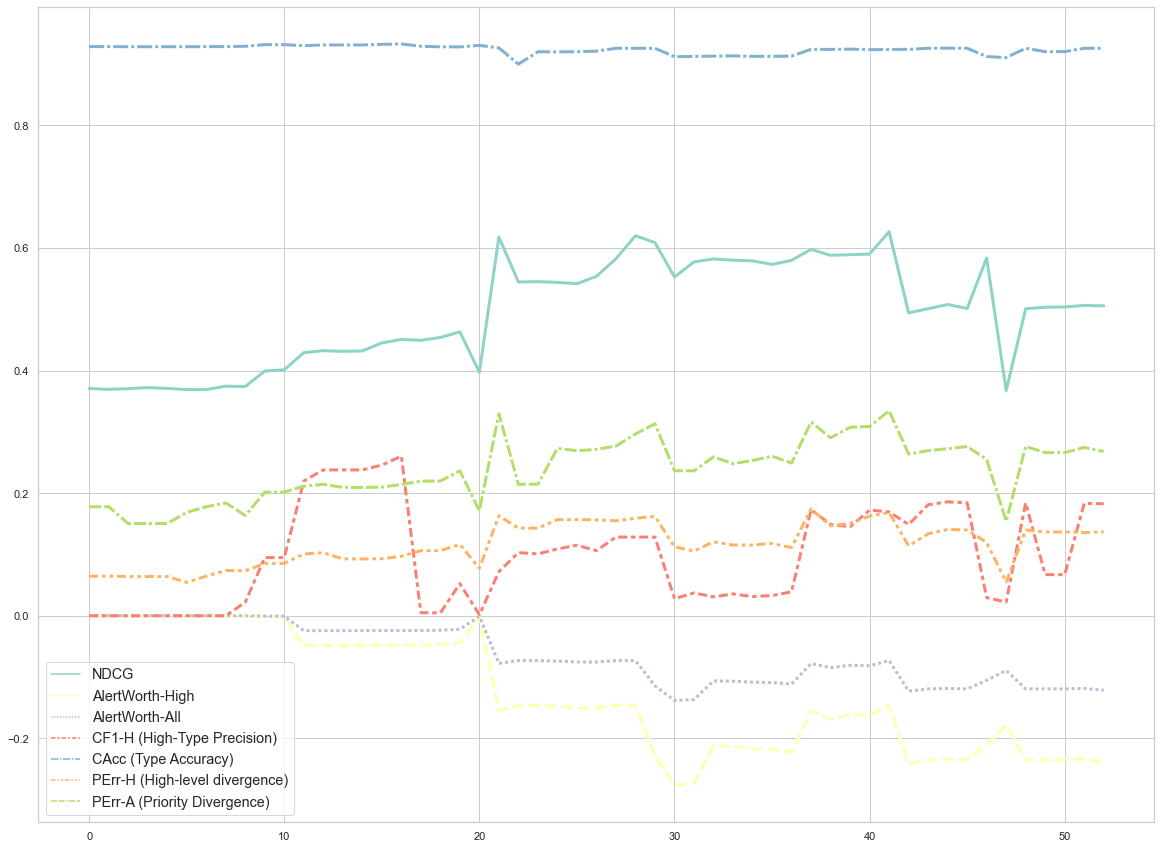

<Figure size 1440x1080 with 0 Axes>

In [281]:
# Results

# Set the figure size
rcParams['figure.figsize'] = 20,15

# Seaborn theme 
sns.set_theme(style="whitegrid")

# Read the results.txt file in
data = pd.read_csv('../../../2-status_report/results.txt', sep="&", header=None)

# Set the column names
data.columns = ["run", "NDCG", "AlertWorth-High" , "AlertWorth-All" , "CF1-H (High-Type Precision)" , "CF1-A (Type Overall Precision)" , "CAcc (Type Accuracy)" , "PErr-H (High-level divergence)", "PErr-A (Priority Divergence)" ]

# Take a rolling mean
#data = data.rolling(7).mean()

sns.lineplot(data=data, palette="Set3", linewidth=3)

# Increase the font-size for the legend
#fig.suptitle('Marks runs')
plt.legend(fontsize='large', title_fontsize='10')

plt.show()

plt.savefig('../../../0-data/screenshots/benchmark_models_performance.png',dpi=300)



LogisticRegression: 0.815973 (0.131238)
LinearDiscriminantAnalysis: 0.847526 (0.114817)
KNeighborsClassifier: 0.758735 (0.215485)
DecisionTreeClassifier: 0.942393 (0.047606)
GaussianNB: 0.784488 (0.158536)
SVC: 0.815973 (0.131238)


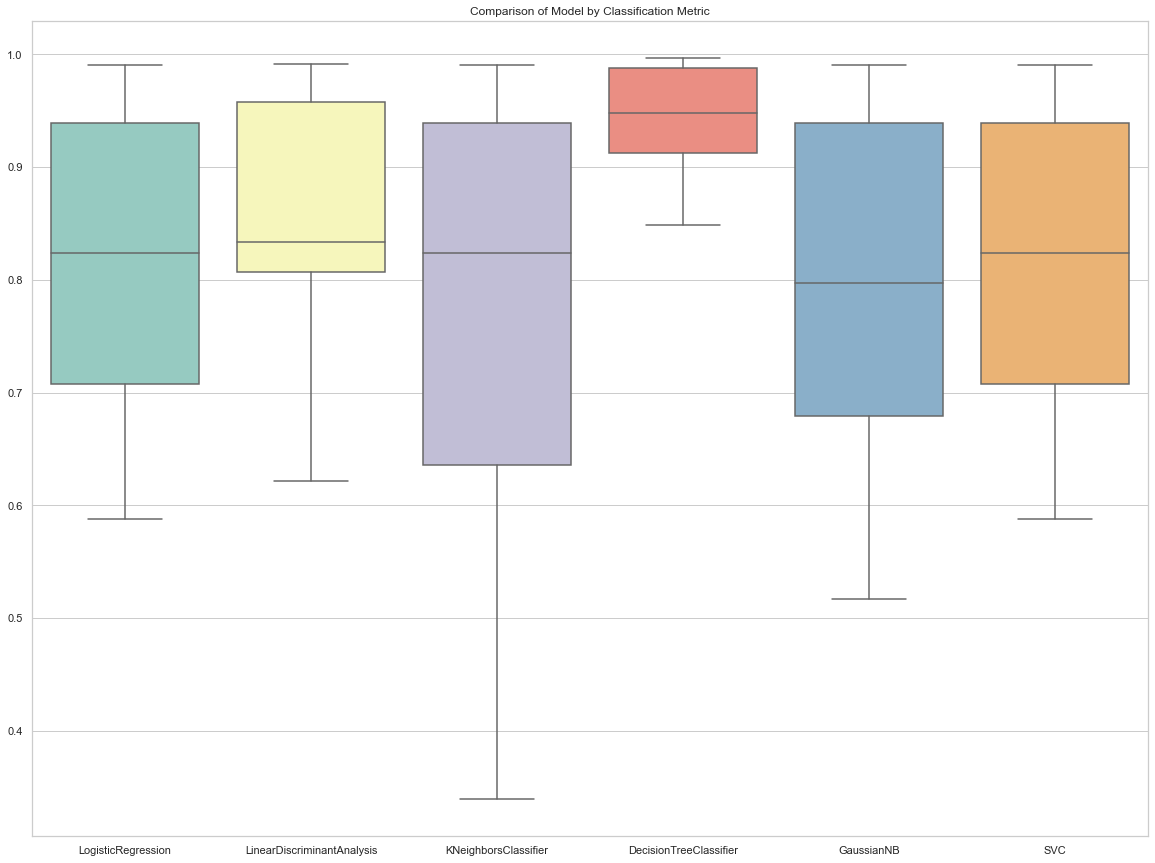

<Figure size 1440x1080 with 0 Axes>

In [200]:
# Algorithm Comparison Boxplot

# load dataset
array = train.values
X = array[:,0:8]
Y = array[:,8]

# prepare configuration for cross validation test harness
seed = 7

# prepare models
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('GaussianNB', GaussianNB()))
models.append(('SVC', SVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
#fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
#plt.boxplot(results)
sns.boxplot(data=results, palette="Set3")
ax.set_xticklabels(names)
plt.title('Comparison of Model by Classification Metric')
plt.show()

plt.savefig('../../../0-data/screenshots/benchmark_models_performance.png',dpi=300)



In [19]:
# example run
# Run             & NDCG    &  AW-H     & AW-A      & CF1-H   & CF1-A   & CAcc   & PErr-H & PErr-A \\
# njit-sub01.text & 0.4632  & -0.4801   & -0.2493   & 0.0792  & 0.1582  & 0.9025 & 0.1524 & 0.2198 \\